In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import expit
from pygam import LinearGAM, LogisticGAM, s, f
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, f1_score, roc_auc_score, precision_score
import matplotlib.pyplot as plt
##sites consulted:
#https://www.geeksforgeeks.org/generalized-additive-model-in-python/
#https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html

In [2]:
data = pd.read_csv('heart.csv')

In [3]:
X = data.drop(columns="target")
y = data.target

In [4]:
X.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2
5,58,0,0,100,248,0,0,122,0,1.0,1,0,2
6,58,1,0,114,318,0,2,140,0,4.4,0,3,1
7,55,1,0,160,289,0,0,145,1,0.8,1,1,3
8,46,1,0,120,249,0,0,144,0,0.8,2,0,3
9,54,1,0,122,286,0,0,116,1,3.2,1,2,2


In [5]:
#Define GAMs, CV, and necessary steps so it can be used outside of the training loop
five_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
GAMs = None
AUC_SCORE = []
F1_SCORE = []
FifthFold = None

In [6]:
# Train and test loop using 5 Fold CV
for fold, (train_index, test_index) in enumerate(five_fold.split(X, y)):    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    GAMs = LogisticGAM(s(0) + f(1) + f(2) + s(3)+ s(4) + f(5) + f(6) + s(7) + f(8) + s(9) + f(10) + f(11) + f(12)).fit(X_train, y_train)
    y_pred = GAMs.predict(X_test)
    y_pred_prob = GAMs.predict_mu(X_test)
    f1 = f1_score(y_test, y_pred)
    auc_of_fold = roc_auc_score(y_test, y_pred)
    AUC_SCORE.append(auc_of_fold)
    F1_SCORE.append(f1)
    
    
    if(fold == 4):       
        precision = precision_score(y_test, y_pred)

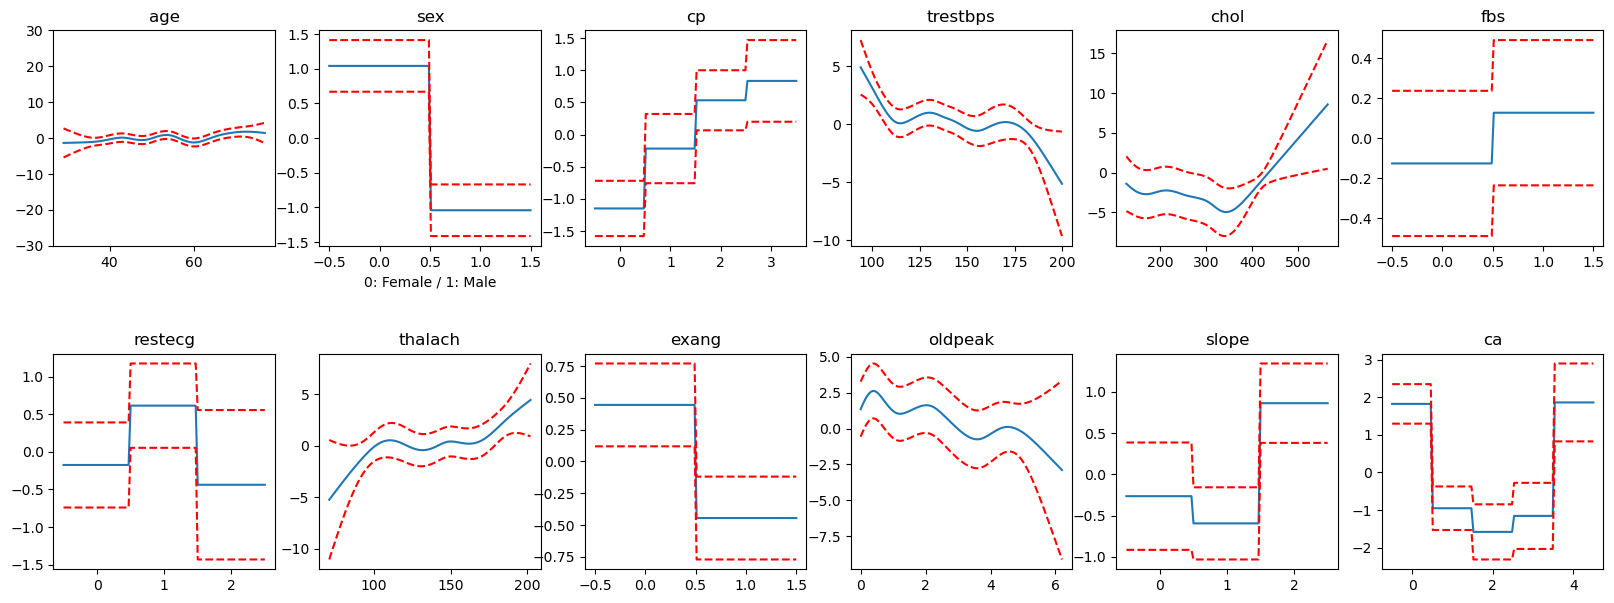

In [7]:
## Generate partial dependence for each feature

# graph prep
fig, axs = plt.subplots(2, 6, figsize=(20, 7))
fig.subplots_adjust(hspace=0.5)
axs = axs.flatten()

## get the feature names
feature_names = X.columns.tolist()

#graph each fig
for i, ax in enumerate(axs):
    XX = GAMs.generate_X_grid(term=i)
    ax.plot(XX[:, i], GAMs.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], GAMs.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(feature_names[i]);
    if i == 1:
        ax.set_xlabel("0: Female / 1: Male")

In [8]:
##Question: I thought males had more heart disease. Next steps is to investigate if the graph above was wrong. 
##Presupposition: Males have a higher likely chance of heart disease

In [9]:
males = data[data["sex"] == 1].reset_index()
females = data[data["sex"] == 0].reset_index()

In [10]:
print("total males", len(males), "/", "males with heart disease", males.target.sum())
print("total females", len(females), "/", "females with heart disease", females.target.sum())

total males 713 / males with heart disease 300
total females 312 / females with heart disease 226


In [11]:
## I was wrong. For this set of data, females are more likely to have heart disease

In [12]:
## recycled draw code from when I took 3202
def aurocDraw(my_model, model_name_string, fig, ax):
    # Get probability scores for the positive class
    model = my_model

    if model_name_string == "LR":
        y_pred = model.decision_function(X_test)
    elif model_name_string == "FOREST":
        y_pred = model.predict_proba(X_test)[:, 1]
    elif model_name_string == "KNN":
        y_pred = model.predict_proba(X_test)[:, 1]
    elif model_name_string == "GAMs":
        y_pred = model.predict_proba(X_test)
    else:
        raise ValueError("Invalid model_name_string")
    
    fpr, tpr, threshold = roc_curve(y_test, y_pred)

    auc_ = auc(fpr, tpr)

    if(model_name_string == "LR"):
        my_label = ("logistic (auc = %0.3f)" % auc_)
    if(model_name_string == "FOREST"):
        my_label = ("Random Forest (auc = %0.3f)" % auc_)
    if(model_name_string == "KNN"):
        my_label = ("KNN (auc = %0.3f)" % auc_)
    
    if(model_name_string == "GAMs"):
        my_label = ("GAMs (auc = %0.3f)" % auc_)

    ax.plot(fpr, tpr, marker=".", label = my_label)
    plt.fill_between(fpr, tpr , 0, alpha=0.2)  # Fills the area under the line

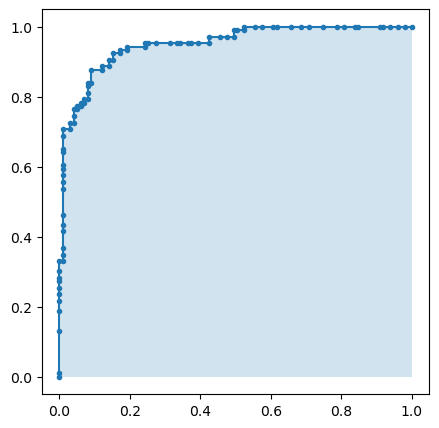

In [13]:
## Draw Area Under the Curve
fig, ax = plt.subplots(figsize = (5,5))
aurocDraw(GAMs, "GAMs", fig, ax )

In [14]:
print("mean F1 : ", np.mean(F1_SCORE))
print("mean AUC: ", np.mean(AUC_SCORE))

mean F1 :  0.8996337071128278
mean AUC:  0.8952336845544393
